# CVAI Project - ZAUBI

In [1]:
import time
import os
import copy
from tqdm import tqdm

import numpy as np
import PIL as PIL
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
import random
import math
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets

from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, models, transforms
from torch.utils import data
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.io import read_image

from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from skimage import io, color
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from zaubi import CustomImageDataset

#from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image

In [38]:
DATA_DIR = 'data/mtg-image-data'

BATCH_SIZE = 32
NUM_WORKERS = 4

# Hyperparameters
LEARNING_RATE = 0.01
NUM_EPOCHS = 10

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

## Data Preprocessing

### Data Collection

In [39]:
# load the dataset from huggingface
from datasets import load_dataset
dataset = load_dataset("Neramas1221/mtg-image-data", split='train')
dataset

In [40]:
#remove image at index 20067
# Identify the corrupted index
corrupted_index = 20067
print(f"Original dataset size: {len(dataset)}")
# Select all rows except the corrupted one
dataset = dataset.select([i for i in range(len(dataset)) if i != corrupted_index])

# Verify the removal

print(f"Cleaned dataset size: {len(dataset)}")

### Feature Engineering

#### Label extraction

In [41]:
from PIL import Image, UnidentifiedImageError


# Function to extract labels from the text
def replace_label(label):
    label = label.replace('C', 'colorless')
    label = label.replace('U', 'blue')
    label = label.replace('B', 'black')
    label = label.replace('W', 'white')
    label = label.replace('G', 'green')
    label = label.replace('R', 'red')
    return label

def extract_label(text):
    labels = re.findall(r", (U|B|W|G|R|C),", text)
    label = None if len(labels) == 0 else replace_label(labels[0])
    return label

# Function to verify image data
def verify_image(image):
    try:
        if isinstance(image, Image.Image):
            image.verify()  # Verify the integrity of the image
        else:
            return False
        return True
    except (UnidentifiedImageError, ValueError, IOError):
        return False

# Function to add mana color and verify image
def add_mana_color_and_verify_image(example):
    example['mana_color'] = extract_label(example['text'])
    example['image_valid'] = verify_image(example['image'])
    return example


In [42]:

# Apply the function to the dataset
dataset = dataset.map(add_mana_color_and_verify_image)

# Filter out rows with invalid image data
valid_image_dataset = dataset.filter(lambda x: x['image_valid'])

# Print the number of valid and invalid images
invalid_image_count = len(dataset) - len(valid_image_dataset)
print(f"Number of invalid images: {invalid_image_count}")
print(f"Number of valid images: {len(valid_image_dataset)}")

# Check for missing labels
def check_missing_label(example):
    return example['mana_color'] is None or example['mana_color'] == ''

# Filter out rows with missing mana_color
missing_label_dataset = valid_image_dataset.filter(check_missing_label)

# Print the number of rows with missing labels
print(f"Number of rows with missing mana_color: {len(missing_label_dataset)}")

# Optionally, filter out rows with missing labels
valid_image_and_label_dataset = valid_image_dataset.filter(lambda x: x['mana_color'] is not None and x['mana_color'] != '')

# Print the number of valid rows with both valid images and labels
print(f"Number of valid rows with valid images and labels: {len(valid_image_and_label_dataset)}")

In [43]:
# save the dataset to disk
dataset = valid_image_and_label_dataset.remove_columns(['image_valid'])
dataset.save_to_disk("data/mtg-image-data")

In [44]:
#load the dataset from disk
from datasets import load_from_disk
dataset = load_from_disk("data/mtg-image-data")
dataset

Dataset({
    features: ['image', 'Unnamed: 0', 'text', 'mana_color'],
    num_rows: 23848
})

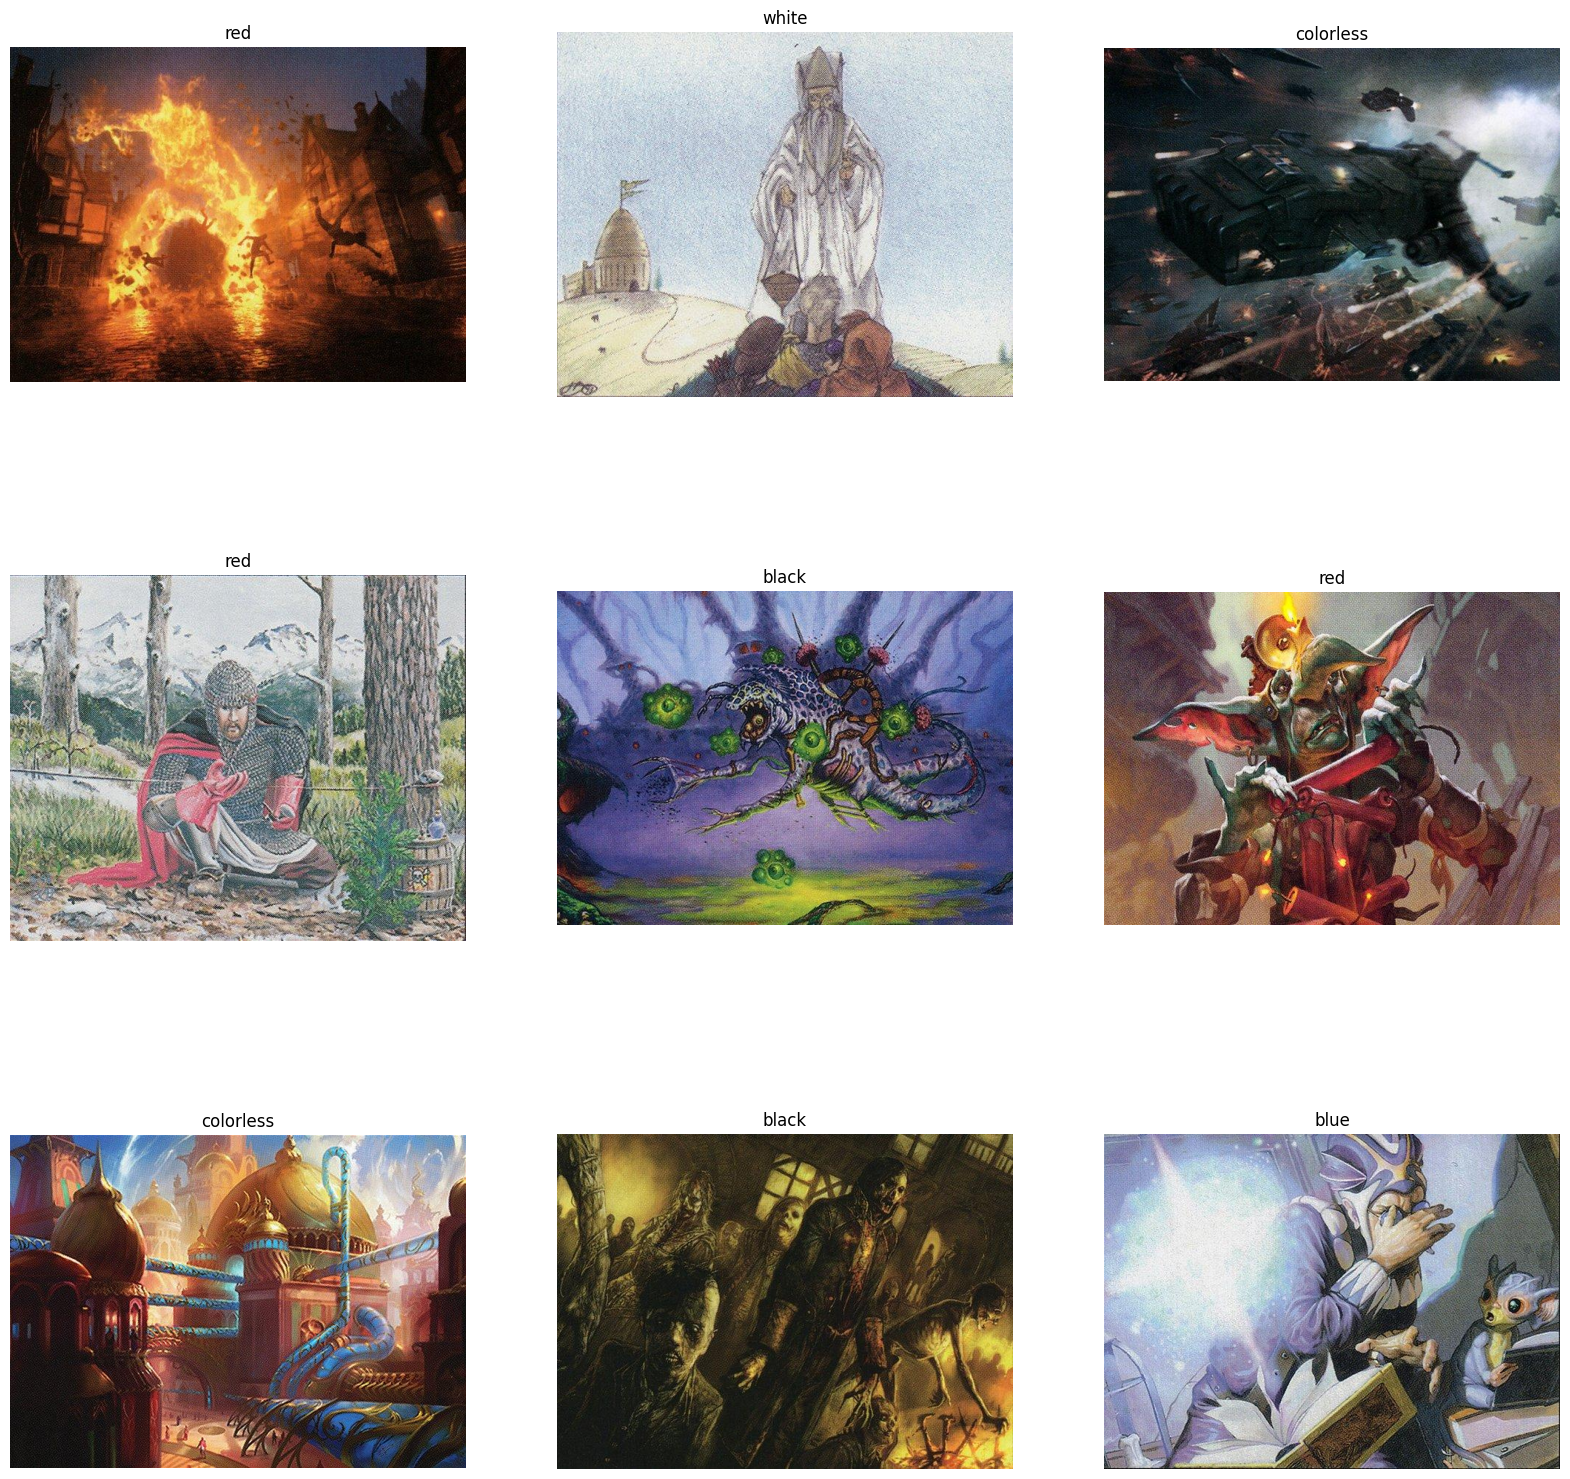

In [47]:
# Define a function to visualize n random images with mana color labels, 3 per row
def visualize_images(dataset, n=9):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        plt.subplot(n // 3, 3, i + 1)
        random_index = random.randint(0, len(dataset))
        image = dataset[random_index]['image']
        label = dataset[random_index]['mana_color']
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Visualize some random images
visualize_images(dataset)



In [49]:
len(dataset)

23848

In [48]:
# Compute the labels distribution

label_counts = {label: 0 for label in labels}
for example in dataset:
    label = example['mana_color']
    label_counts[label] += 1
label_counts

{'colorless': 5381,
 'blue': 3632,
 'black': 3725,
 'white': 3749,
 'green': 3716,
 'red': 3645}

In [52]:
# plot the distribution of labels
fig = px.bar(x=labels, y=[label_counts[label] for label in labels], title='Mana Color Distribution', color = labels, color_discrete_map = {'colorless': 'gray', 'blue': 'deepskyblue', 'black': 'black', 'white': 'cornsilk', 'green': 'darkgreen', 'red': 'firebrick'})
fig.update_layout(xaxis_title='Mana Color', yaxis_title='Count', showlegend=False)
fig.show()

In [51]:
dataset 

Dataset({
    features: ['image', 'Unnamed: 0', 'text', 'mana_color'],
    num_rows: 23848
})

## Model Building

### Load the pre-trained model

In [53]:
import ssl
from torchvision.models import resnet50, ResNet50_Weights

ssl._create_default_https_context = ssl._create_unverified_context

# Initialize the Weight Transform
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()

model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [54]:
# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

In [55]:
# Modify the last layer of the model
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, len(labels))
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [57]:
# Split the dataset into train, val, and test sets (e.g., 80% train, 10% val, 10% test)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])



Train dataset size: 19078
Val dataset size: 2384
Test dataset size: 2386


In [18]:
# Define the training function with learning rate scheduler and early stopping
def train(model, train_dataset, val_dataset, criterion, optimizer, num_epochs, patience):
    
    # Apply transformations to each split
    train_trans = CustomImageDataset(train_dataset, labels, transform=transform)
    val_trans = CustomImageDataset(val_dataset, labels,  transform=transform)
    
    # Create DataLoaders
    train_loader = DataLoader(train_trans, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_trans, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # Initialize early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Define a learning rate scheduler
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            # Move the inputs and labels to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                # Move the inputs and labels to the device
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.double() / len(val_loader.dataset)

        # Print the epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

        # Learning rate scheduler step
        scheduler.step()

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break


In [62]:
# Define transformations including data augmentation for the training set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for the validation and test sets
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a similar training function that implements stratified k-fold CV and data augmentation
def train_k_fold(model, dataset, labels, criterion, optimizer, num_epochs, k=5, patience=3):
    # Initialize the StratifiedKFold object
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Initialize the running loss and accuracy
    running_loss = 0.0
    running_corrects = 0

    for fold, (train_index, val_index) in enumerate(skf.split(dataset, dataset['mana_color'])):
        print(f"Fold {fold+1}/{k}")

        # Split the dataset into train and validation sets
        train_dataset = Subset(dataset, train_index.tolist())
        val_dataset = Subset(dataset, val_index.tolist())
        
        # Apply transformations to each split
        train_dataset = CustomImageDataset(train_dataset, labels, transform=train_transform)
        val_dataset = CustomImageDataset(val_dataset, labels, transform=val_test_transform)
        
        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        
        # Train the model
        train(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience)


In [63]:
# Set the device
model.to(DEVICE)

# Fine-tune the last layer for a few epochs
optimizer = torch.optim.SGD(model.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
# train(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)
train_k_fold(model, torch.utils.data.ConcatDataset([train_dataset, val_dataset]), labels, criterion, optimizer, num_epochs=NUM_EPOCHS, k=5, patience=3)

# # Unfreeze all the layers and fine-tune the entire network for a few more epochs
# for param in model.parameters():
#     param.requires_grad = True
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Fold 1/5
Epoch 1/20


Training:   2%|▏         | 11/597 [00:30<22:17,  2.28s/it] 

In [ ]:
# make n predictions and visualize the original image, the transformed image, the label, predicted label and probabilities 

def visualize_predictions(model, test_dataset, transform, labels_names, n_images=10):
    model.eval()
    # Sample n random images
    samples, _ = torch.utils.data.random_split(test_dataset, [n_images, len(test_dataset) - n_images])
    # Store original images
    original_images = []
    for sample in samples:
        original_images.append(sample['image'])
    # Apply transformations
    samples = CustomImageDataset(samples, labels_names, transform=transform)
    # Create DataLoader
    test_loader = DataLoader(samples, batch_size=n_images, shuffle=False)
    # prepare the figure
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 20))
    # Iterate over the batches of the test loader
    for i, (inputs, labels) in enumerate(test_loader):
        # Move the inputs and labels to the device
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        # Iterate over the images in the batch
        for j in range(inputs.size()[0]):
            # Original image
            axes[j, 0].imshow(original_images[j])
            axes[j, 0].axis('off')
            # add the label as title
            axes[j, 0].set_title(f"True: {labels_names[labels[j]]}")
            # Transformed image
            transformed_image = transforms.ToPILImage()(inputs[j].cpu())
            axes[j, 1].imshow(transformed_image)
            axes[j, 1].axis('off')
            # add the predicted label and probabilities as title
            axes[j, 1].set_title(f"Pred: {labels_names[preds[j]]}\n{probs[j].cpu().detach().numpy()}")
    plt.tight_layout()
    plt.show()

 
    
    


In [ ]:
# save the model to disk
torch.save(model.state_dict(), "mtg_image_classifier.pth")

In [ ]:
# load the model from disk
model.load_state_dict(torch.load("mtg_image_classifier.pth"))

In [ ]:
# Evaluate the model on the test set
def evaluate(model, test_loader):
    # Set the model to evaluation mode
    model.eval()

    # Initialize the running loss and corrects
    running_loss = 0.0
    running_corrects = 0

    # Initialize the predictions and labels list
    all_preds = []
    all_labels = []

    # Iterate over the batches of the test loader
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            # Move the inputs and labels to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Update the running loss and corrects
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Append the predictions and labels to the lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Calculate the test loss and accuracy
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    
    return test_loss, test_acc, all_preds, all_labels

# Evaluate the model
test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")
    